## CS 6120: Natural Language Processing - Prof. Ahmad Uzair

### Assignment 1: Naive Bayes
### Total Points: 100 points

You will be dealing with movie review data that includes both positive and negative reviews in this assignment. You will use Sentiment Analysis to assess if a given review is positive or negative using the provided dataset.

Therefore, we will make use of Naive Bayes algorithm to perform sentiment analysis on the movie review dataset.

## Importing the Libraries

In [1]:
import numpy as np
import math
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")

In [2]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
import string
from bs4 import BeautifulSoup

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Reading the data

When reading the data, ensure that the '.csv' file is in the same location where your jupyter notebook is used. This way the files are organized and easy to read using the pandas library. 

In [3]:
## Reading the data and removing columns that are not important. 
df = pd.read_csv('movie_reviews.csv', sep = ',', encoding = 'latin-1')

In [4]:
df.head()  # print head of data frame with help of head function

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,"Petter Mattei's ""Love in the Time of Money"" is...",positive
4,"Probably my all-time favorite movie, a story o...",positive


## Count plot of the output categories: positive or negative

Feel free to take a look at the output and whether the classes are balanced or imbalanced. 

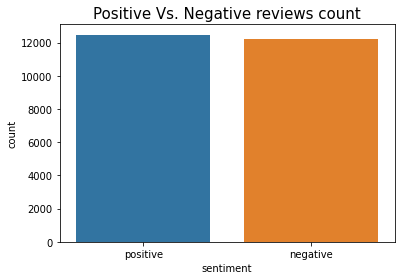

In [5]:
plt.figure(figsize = None)
sns.countplot(df['sentiment'])
plt.title("Positive Vs. Negative reviews count", fontsize = 15)
plt.show()


## Upsampling the minority class: (5 points)

It is known that Naive bayes is not robust to class imbalance. It could be seen above that the data is little imbalanced. Therefore, class balancing can be done before giving it to the Naive Bayes model for prediction. 

Feel free to use 'resample' library from sklearn. 

In [6]:
## hint: use resample from sklearn.utils
from sklearn.utils import resample

df_majority = df[df['sentiment']=='positive']
df_minority = df[df['sentiment']=='negative']

negative_upsample = resample(df_minority, replace = True, 
                        n_samples = df_majority.shape[0],
                        random_state = 101)

df_upsampled = pd.concat([df_majority, negative_upsample])  # concat two data frames i,e majority class data set and upsampled minority class data set
df_upsampled = df_upsampled.sample(frac = 1)

In [7]:
## Just to ensure that upsampling was done successfully, take a look at the shape of the data in 
## this cell. 

# print the shape of data set with the help of shape function having "negative" as class label
df_upsampled[df['sentiment']=='negative'].shape

(12474, 2)

### Expected Output : 
(12474, 2)

In [8]:
## Ensure that the same number of data points are present for both 'positive' and 'negative' data

# print the shape of data set with the help of shape function having "positive" as class label
df_upsampled[df['sentiment']=='positive'].shape

(12474, 2)

### Expected Output : 
(12474, 2)

In [9]:
## In this cell, we are going to be dividing the data into train and test points
## Ensure that you store the upsampled data in a variable called 'df_upsampled' 
## so that the below operations are performed successfully


## Considering 10000 positive and 10000 negative data points
negative_data_points_train = df_upsampled[df_upsampled['sentiment']=='negative'].iloc[:10000]
positive_data_points_train = df_upsampled[df_upsampled['sentiment']=='positive'].iloc[:10000]

## Considering the remaining data points for test
negative_data_points_test = df_upsampled[df_upsampled['sentiment']=='negative'].iloc[10000:]
positive_data_points_test = df_upsampled[df_upsampled['sentiment']=='positive'].iloc[10000:]

## Concatenate the training positive and negative reviews
X_train = pd.concat([negative_data_points_train['review'], positive_data_points_train['review']])
## Concatenating the training positive and negative outputs
y_train = pd.concat([negative_data_points_train['sentiment'], positive_data_points_train['sentiment']])

## Concatenating the test positive and negative reviews
X_test = pd.concat([negative_data_points_test['review'], positive_data_points_test['review']])
## Concatenating the test positive and negative outputs
y_test = pd.concat([negative_data_points_test['sentiment'], positive_data_points_test['sentiment']])


In [10]:
## Take a look at the total number of classes and their count using '.value_counts()' for y_train and y_test.
## Ensure that there are equal number of positive and negative reviews. 
y_train.value_counts()

negative    10000
positive    10000
Name: sentiment, dtype: int64

### Expected Output:
negative    10000<br>
positive    10000<br>
Name: sentiment, dtype: int64

In [11]:
y_test.value_counts()

negative    2474
positive    2474
Name: sentiment, dtype: int64

### Expected Output : 
negative    2474<br>
positive    2474<br>
Name: sentiment, dtype: int64

In [12]:
lemmatizer = WordNetLemmatizer()
stopwords_english = stopwords.words('english')

## Q1. Pre-process the reviews: (10 points)

We know that a review contains links, punctuation, stopwords and many other words that don't give a lot of meaning for the Naive Bayes model for prediction. 

In the cell below, one must implement text-preprocessing and remove links, punctuations and stopwords. It is also important to lowercase the letters so that 'Admire' and 'admire' are not treated as different words. 

In addition to this, perform stemming operation so that similar words are reduced. To know more about stemming, feel free to take a look at this link.

https://nlp.stanford.edu/IR-book/html/htmledition/stemming-and-lemmatization-1.html

In [13]:
# TASK CELL

def clean_review(review):
    '''
    Input:
        review: a string containing a review.
    Output:
        review_cleaned: a processed review. 

    '''
    review = review.lower()
    review = " ".join([word for word in review.split() if word not in stopwords_english])
    review=re.sub(r'http\S+', '', review, flags=re.MULTILINE)
    review = re.sub(r'[^\w\s]', '', review)
    review=word_tokenize(review)
    review_cleaned = [lemmatizer.lemmatize(word) for word in review]
    review_cleaned=" ".join([word for word in review_cleaned])


    return review_cleaned

## Q2. Implement a find_occurrence function (5 points):

In this function, we find the total occurrence of a word giving information such as label, word and frequency dictionary.

Note that this function is used later in the code when we are going to be predicting the output using Naive Bayes. 

In [14]:
# TASK CELL
def find_occurrence(frequency, word, label):
    '''
    Params:
        frequency: a dictionary with the frequency of each pair (or tuple)
        word: the word to look up
        label: the label corresponding to the word
    Return:
        n: the number of times the word with its corresponding label appears.
    '''

    #
    n=0
    if (word,label) in frequency.keys():
      return frequency[(word,label)]
  
    return n


### Converting output to numerical format:

We have outputs as 'positive' or 'negative'. In the cell below, we convert it to a numerical format. 

In [15]:
## With the use of mapping function, we replace
## the label in the form of string to an integer. 

output_map = {'positive': 0, 'negative': 1}
y_train = y_train.map(output_map)
y_test = y_test.map(output_map)

In [16]:
## Ensuring that there are equal number of classes on the training data. 
y_train.value_counts()

1    10000
0    10000
Name: sentiment, dtype: int64

In [17]:
## Choosing a random review and taking a look at it.
X_train.iloc[0]

'If there\'s one thing I want to distinguish myself from all the other great reviewers here, it\'s that I am the Queen of Finding Strange Movies in Thrift and Dollar Stores. That said, you can\'t possibly imagine how happy I was when I found this one. <br /><br />I can even remember that Saturday morning when *every* station simulcast it, so you were stuck if you wanted to watch something else (then again, I guess that was the idea). As a kid, I didn\'t know if I liked the way all the different characters were stuck together (there are some crossovers that just do *not* work). But I guess the special had it\'s intended effect. Don\'t do drugs because you will have nightmares about the Muppets.<br /><br />Now, if you watch this as an adult, on the other hand, you will be treated to the *strangest* anti-drug movie this side of "Reefer Madness". I think I\'ll just leave it at that before I get into trouble.'

From the above cell output, it could be seen that there are a lot of words that don't add a lot of meaning to the text. 

Therefore, those words would be removed. It also reduces the computation time. 

Therefore, it is a good practice we are following.

In [18]:
custom_review = X_train.iloc[0]

# print cleaned review
print(clean_review(custom_review))

there one thing want distinguish great reviewer here queen finding strange movie thrift dollar store said cant possibly imagine happy found one br br i even remember saturday morning every station simulcast it stuck wanted watch something else then again guess idea kid know liked way different character stuck together there crossover not work guess special intended effect drug nightmare muppetsbr br now watch adult hand treated strangest antidrug movie side reefer madness think ill leave get trouble


We now use this function to pre-process the review and remove words that don't add a lot of meaning in our model. 

## Q3. Implementing review counter function: (5 points)

It is now time to implement the count function for the reviews. 

In this function, we count the occurrence of words and get the probabilities 
for the words based on the training data. 

In other words, we get the probability of occurrence of a word, given that the output is 'positive'.

Similarly, we also compute the probability of occurence of a word, given that the output is 'negative'.



In [19]:
# TASK CELL
def review_counter(output_occurrence, reviews, positive_or_negative):
    '''
    Params:
        output_occurrence: a dictionary that will be used to map each pair to its frequency
        reviews: a list of reviews
        positive_or_negative: a list corresponding to the sentiment of each review (either 0 or 1)
    Return:
        output: a dictionary mapping each pair to its frequency
    '''
    ## Steps :
    # define the key, which is the word and label tuple
    # if the key exists in the dictionary, increment the count
    # else, if the key is new, add it to the dictionary and set the count to 1

    for label, review in zip(positive_or_negative, reviews):
      split_review = clean_review(review).split()
      for word in split_review:
        # Your code here
        n = find_occurrence(output_occurrence,word,label)
        output_occurrence[(word,label)] = n+1
   
    return output_occurrence
   


### Test your function with example reviews:

Feel free to run the cell below and understand whether the above function that you have defined is producing the optimum results. 

In [20]:
# Testing your function

result = {}
reviews = ['got bored throught the moview', 'The movie was fantastic', 'Will not watch it again', 'Was bored, it was a complete waste of time and money', 'Enjoyed the movie to the fullest']
ys = [1, 0, 1, 1, 0]
review_counter(result,reviews, ys)

{('bored', 1): 2,
 ('complete', 1): 1,
 ('enjoyed', 0): 1,
 ('fantastic', 0): 1,
 ('fullest', 0): 1,
 ('got', 1): 1,
 ('money', 1): 1,
 ('movie', 0): 2,
 ('moview', 1): 1,
 ('throught', 1): 1,
 ('time', 1): 1,
 ('waste', 1): 1,
 ('watch', 1): 1}

### Expected Output:
 {('bored', 1): 2, <br>
 ('complete', 1): 1, <br>
 ('enjoyed', 0): 1, <br>
 ('fantastic', 0): 1, <br>
 ('fullest', 0): 1, <br>
 ('got', 1): 1, <br>
 ('money', 1): 1, <br>
 ('movie', 0): 2, <br>
 ('moview', 1): 1, <br>
 ('throught', 1): 1, <br>
 ('time', 1): 1, <br>
 ('waste', 1): 1, <br>
 ('watch', 1): 1}

In [21]:
# Build the freqs dictionary for later uses

freqs = review_counter({}, X_train, y_train)

In [22]:
## Run this cell to get an idea about the corpus of words and their occurrence along with labels. 
## In this, we are computing the frequency of occurrence of word given that a review is 'positive'.
## Similarly, we also compute the frequence of occurence of word given that a review is 'negative'.
freqs

{('there', 1): 2380,
 ('one', 1): 10442,
 ('thing', 1): 3667,
 ('want', 1): 2077,
 ('distinguish', 1): 30,
 ('great', 1): 2143,
 ('reviewer', 1): 200,
 ('here', 1): 1096,
 ('queen', 1): 144,
 ('finding', 1): 128,
 ('strange', 1): 346,
 ('movie', 1): 22425,
 ('thrift', 1): 3,
 ('dollar', 1): 183,
 ('store', 1): 220,
 ('said', 1): 1023,
 ('cant', 1): 1823,
 ('possibly', 1): 328,
 ('imagine', 1): 309,
 ('happy', 1): 260,
 ('found', 1): 955,
 ('br', 1): 23234,
 ('i', 1): 2317,
 ('even', 1): 6149,
 ('remember', 1): 562,
 ('saturday', 1): 93,
 ('morning', 1): 116,
 ('every', 1): 1554,
 ('station', 1): 138,
 ('simulcast', 1): 1,
 ('it', 1): 5147,
 ('stuck', 1): 152,
 ('wanted', 1): 632,
 ('watch', 1): 2833,
 ('something', 1): 2239,
 ('else', 1): 932,
 ('then', 1): 433,
 ('again', 1): 743,
 ('guess', 1): 667,
 ('idea', 1): 1337,
 ('kid', 1): 1132,
 ('know', 1): 2982,
 ('liked', 1): 429,
 ('way', 1): 3171,
 ('different', 1): 618,
 ('character', 1): 5623,
 ('together', 1): 750,
 ('crossover', 1)

## Q4. Training the Naive Bayes Model: (20 points)

Now we are in the training phase of the Naive Bayes algorithm. In this cell, take a look at the ways to calculate the log likelihood and log prior values as these are important for testing in the next few cells. 

Also calculate the frequency of occurrence of words where the output is negative. In the same way, calculate the word frequency count using the above functions in order to compute the log likelihood.

Return the logprior and loglikelihood output by the model from this function. 

In [23]:
def train_naive_bayes(freqs, train_x, train_y):
    '''
    Input:
        freqs: dictionary from (word, label) to how often the word appears
        train_x: a list of reviews
        train_y: a list of labels correponding to the reviews (0,1)
    Output:
        logprior: the log prior. (equation 3 above)
        loglikelihood: the log likelihood of you Naive bayes equation. (equation 6 above)
    '''
    loglikelihood = {}
    logprior = 0


    # calculate V, the number of unique words in the vocabulary
    vocab = set([pair[0] for pair in freqs.keys()])
    V = len(vocab)

    # calculate num_pos and num_neg - the total number of positive and negative words for all documents
    num_pos = num_neg = 0
    for pair in freqs.keys():
        # if the label is positive (greater than zero)
        if pair[1] == 0:

            # Increment the number of positive words by the count for this (word, label) pair
            num_pos += freqs[pair]

        # else, the label is negative
        else:

            # increment the number of negative words by the count for this (word,label) pair
            num_neg += freqs[pair]


    # Calculate num_doc, the number of documents
    num_doc = len(train_y)

    # Calculate D_pos, the number of positive documents 
    pos_num_docs = np.sum([train_y==0])

    # Calculate D_neg, the number of negative documents 
    neg_num_docs = num_doc-pos_num_docs

    # Calculate logprior
    logprior = np.log(neg_num_docs)-np.log(pos_num_docs)

    # For each word in the vocabulary...
    for word in vocab:
        # get the positive and negative frequency of the word
        freq_pos = find_occurrence(freqs,word,0)
        freq_neg = find_occurrence(freqs,word,1)

        # calculate the probability that each word is positive, and negative
        p_w_pos = (freq_pos+1)/(num_pos+V)
        p_w_neg = (freq_neg+1)/(num_neg+V)

        # calculate the log likelihood of the word
        loglikelihood[word] = np.log(p_w_neg) - np.log(p_w_pos)


    return logprior, loglikelihood

In [24]:
# You do not have to input any code in this cell, but it is relevant to grading, so please do not change anything
logprior, loglikelihood = train_naive_bayes(freqs, X_train, y_train)
print(logprior)
print(len(loglikelihood))

0.0
92197


### Expected Output 

0.0 <br>
91425

## Q5. Implementing Naive Bayes Predict Function: (10 points)

It is now time to make our prediction as to whether a given review is negative or positive respectively. 

After adding the log likelihood values, ensure that the output is 1 (negative) if the sum of the log likelihood value is greater than 0 and 0 (positive) if the sum of the log likelihood is less than or equal to 0. 

In [25]:
# TASK 4 CELL

def naive_bayes_predict(review, logprior, loglikelihood):
    '''
    Params:
        review: a string
        logprior: a number
        loglikelihood: a dictionary of words mapping to numbers
    Return:
        total_prob: the sum of all the loglikelihoods of each word in the review (if found in the dictionary) + logprior (a number)

    '''
    
      # process the review to get a list of words
    cl_rev = clean_review(review)
    word_l=cl_rev.split()

    # initialize probability to zero
    total_prob = 0

    # add the logprior
    total_prob = total_prob+logprior

    for word in word_l:

        # check if the word exists in the loglikelihood dictionary
        if word in loglikelihood.keys():
            # add the log likelihood of that word to the probability
            total_prob = total_prob + loglikelihood[word]
            
    if (total_prob>0):
      total_prob=1
    else:
      total_prob =0


    return total_prob

In [26]:
# You do not have to input any code in this cell, but it is relevant to grading, so please do not change anything

# Experiment with your own review.
my_review = "I thought this series was going to be another fun, action series with some dynamic plots and great performances. I was wrong. While I like Jamie Denton, this show is hardly worth watching at all, unless you enjoy watching some people brutalized and the actions of the agents supposedly warranted under the theme of national security. The show is great propaganda for the current government, and spews out jingoism as though we talk that way every day. After a couple of episodes, it was boring the hell out of me, and I started watching reruns of House Invaders on BBCAmerica instead. Rather watch CSI and Without a Trace, without a doubt."
p = naive_bayes_predict(my_review, logprior, loglikelihood)
print('The expected output is', p)

The expected output is 1


### Expected Output :
The expected output is 1

## Q6. Implementing Naive Bayes Test function: (10 points)

In this function, implement the previous functions such as naive_bayes_predict to get the predictions for the test set. 

In addition to this, the function should return the total number of reviews that it correctly classified as 'positive' or 'negative'. 

In [27]:
# UNQ_C6 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
def test_naive_bayes(test_x, test_y, logprior, loglikelihood):
    """
    Input:
        test_x: A list of reviews
        test_y: the corresponding labels for the list of reviews
        logprior: the logprior
        loglikelihood: a dictionary with the loglikelihoods for each word
    Output:
        accuracy: (# of reviews classified correctly)/(total # of reviews)
    """
    accuracy = 0  

    
    y_hats =[]
    for review in test_x:
       
        # if the prediction is > 0
        if naive_bayes_predict(review, logprior, loglikelihood) > 0:
            # the predicted class is 1
            y_hat_i = 1
        else:
            # otherwise the predicted class is 0
            y_hat_i = 0
        

        # append the predicted class to the list y_hats
        y_hats.append(y_hat_i) 

    # error is the average of the absolute values of the differences between y_hats and test_y
    error = np.sum([y_hats!=test_y])/len(test_y)

    accuracy = 1-error


    return accuracy

In [28]:
# For grading purpose only
# You do not have to input any code in this cell, but it is relevant to grading, so please do not change anything

# Run this cell to test your function

for review in ["If you like original gut wrenching laughter you will like this movie. If you are young or old then you will love this movie, hell even my mom liked it.<br /><br />Great Camp!!!",
                "What a waste of talent. A very poor, semi-coherent, script cripples this film. Rather unimaginative direction, too. Some VERY faint echoes of Fargo here, but it just doesn't come off.",
                "I have seen this film at least 100 times and I am still excited by it, the acting is perfect and the romance between Joe and Jean keeps me on the edge of my seat, plus I still think Bryan Brown is the tops. Brilliant Film.",
                "Cheap, amateurish, unimaginative, exploitative... but don't think it'll have redeeming amusement value. About as unentertaining, uninstructive and just plain dull as a film can be."]:
    p = naive_bayes_predict(review, logprior, loglikelihood)
    print(f'{review[:100]} -> {p:.2f}')
    

If you like original gut wrenching laughter you will like this movie. If you are young or old then y -> 0.00
What a waste of talent. A very poor, semi-coherent, script cripples this film. Rather unimaginative  -> 1.00
I have seen this film at least 100 times and I am still excited by it, the acting is perfect and the -> 0.00
Cheap, amateurish, unimaginative, exploitative... but don't think it'll have redeeming amusement val -> 1.00


### Expected Output :

If you like original gut wrenching laughter you will like this movie. If you are young or old then y -> 0.00 <br>
What a waste of talent. A very poor, semi-coherent, script cripples this film. Rather unimaginative  -> 1.00<br>
I have seen this film at least 100 times and I am still excited by it, the acting is perfect and the -> 0.00 <br>
Cheap, amateurish, unimaginative, exploitative... but don't think it'll have redeeming amusement val -> 1.00



In [29]:
# Feel free to check the sentiment of your own review below
my_review = 'The moview was very boring, I wanted to leave in the middle'
naive_bayes_predict(my_review, logprior, loglikelihood)

1

### Expected Output :
1

In [30]:
test_naive_bayes(X_test, y_test, logprior, loglikelihood)

0.8876313662085691

# Q7. Evaluate the accuracy (10 Points)
1. Split your data into training and test sets using random selection. Set the seed as parameter of the function so that user can select a different training and test set by changin seed.

2. Calculate model paramters with training set.

3. Print confusion matrix for training and test set.

4. Examine False Positive and False Negative cases and provide reasoning why they get misclassified.

In [31]:
df_upsampled['sentiment'][df_upsampled['sentiment']=='positive']=0
df_upsampled['sentiment'][df_upsampled['sentiment']=='negative']=1
df_upsampled

,review,sentiment
24671,If there's one thing I want to distinguish mys...,1
17930,I wasted enough time actually WATCHING this ch...,1
20786,For that matter one of the worst FILMS ever ma...,1
6520,"Am I the only one to notice that the ""realism""...",1
12606,The writers probably had no experience in the ...,1
...,...,...
12077,"I saw this movie, just now, not when it was re...",1
10205,This show probably won't appeal to everyone. S...,0
21890,I really didn't have high expectations and I m...,1
21152,"This is a great movie, I did the play a while ...",0


In [32]:
X=df_upsampled['review']
Y=df_upsampled['sentiment']

In [33]:
from sklearn.model_selection import train_test_split
X_train1, X_test1, y_train1, y_test1 = train_test_split(  X, Y, test_size=0.33, random_state=42)

In [34]:
freqs1 = review_counter({}, X_train1, y_train1)

In [35]:
logprior1, loglikelihood1 = train_naive_bayes(freqs1, X_train1, y_train1)
print(logprior1)
print(len(loglikelihood1))

0.008734724993106013
84359


In [36]:
test_naive_bayes(X_test1, y_test1, logprior1, loglikelihood1)

0.8727073970606097

In [37]:
Y_train_pred=[]
for review in X_train1:
  val=naive_bayes_predict(review, logprior1, loglikelihood1)
  Y_train_pred.append(val)


In [38]:
type(Y_train_pred[0])

int

In [39]:
y_train1.dtype

dtype('O')

In [40]:
y_train_c=y_train1.astype('int64')

In [41]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_c,Y_train_pred)

array([[7674,  647],
       [ 276, 8118]])

In [42]:
Y_test_pred=[]
for review in X_test1:
  val=naive_bayes_predict(review, logprior1, loglikelihood1)
  Y_test_pred.append(val)

In [43]:
y_test_c=y_test1.astype('int64')

In [44]:
confusion_matrix(y_test_c,Y_test_pred)

array([[3493,  660],
       [ 388, 3692]])

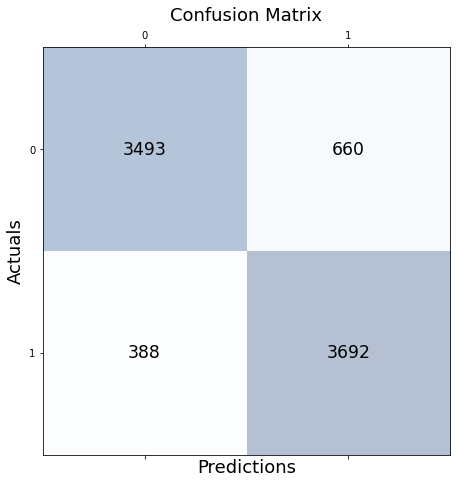

In [45]:
import matplotlib.pyplot as plt

con=confusion_matrix(y_test_c,Y_test_pred)
fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(con, cmap=plt.cm.Blues, alpha=0.3)
for i in range(con.shape[0]):
    for j in range(con.shape[1]):
        ax.text(x=j, y=i,s=con[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

As per the confusion matrix, the number of positive reviews that are misclassified as negative reviews are more. On examining the freqs dictionary, it was found that certain words are repeated more number of times in negative reviews than positive reviews though they are present in both reviews. Also, the number of words in negative reviews are more than the positve words. This is a reasonable explanation for the missclassification.

Also for missclasification of positive to negative review and negative to positive review, the margin of log probability is close due to the variations in occurence of words in both kind of reviews.

# Q8. Modularize your calssifier (10 points)
1. Convert your code into a python module text_classifier.py

2. The user should be able to launch the application on command prompt using python test_classifier.py command. The module will automatically load the model paramters from a local file of your choice and be ready to take the input from user on command prompt. The program will preprocess user input, tokenize and predict the class.

3. Your module will take the input from user and output sentiment class in an indefinite loop. The output should printout the probabilities for each input token along with the final classification decision. Program will quit if user enters X.


In [46]:
param_df=pd.DataFrame({'Parameter':['LogPrior'],'Values':[logprior]})
key_vals=[]
prob_vals=[]
for key in loglikelihood:
  key_vals.append(key)
  prob_vals.append(loglikelihood[key])

dummy_df=pd.DataFrame({'Parameter':key_vals,'Values':prob_vals})
param_df=param_df.append(dummy_df,ignore_index=True)
param_df

,Parameter,Values
0,LogPrior,0.000000
1,superficially,0.934159
2,taket,1.116480
3,frider,-0.675279
4,planner,-0.205275
...,...,...
92193,graduating,-1.773891
92194,hommages,-0.675279
92195,agreeably,0.017868
92196,frenchgerman,-0.675279


In [47]:
param_df.to_csv ('export_dataframe.csv', index = False, header=True)


# Q9. Theory Questions: (10 points)

1. Why is Laplace Smoothing or Additive Smoothing required while executing Naive Bayes operations, especially for text classification? Show how not having additive smoothing leads to bad outcomes by using an example of training and the test set. (10 points)


2. Why are logarithmic values computed instead of only probability values in the Naive Bayes algorithm? (5 points)

1. Laplace smoothing or additive smoothing is required to be applied to Naive Bayes operations to address the issue of zero probability.

If a specific word or feature is missing in one of the classes, it frequency based probability estimate would be calculated to be zero.

This will make class posterior probability to be zero, when individual feature probabilites are multiplied. To avoid this laplace smoothing is applied.

In [48]:
def train_naive_bayes_sample(freqs, train_x, train_y):
    '''
    Input:
        freqs: dictionary from (word, label) to how often the word appears
        train_x: a list of reviews
        train_y: a list of labels correponding to the reviews (0,1)
    Output:
        logprior: the log prior. (equation 3 above)
        loglikelihood: the log likelihood of you Naive bayes equation. (equation 6 above)
    '''
    loglikelihood = {}
    logprior = 0


    # calculate V, the number of unique words in the vocabulary
    vocab = set([pair[0] for pair in freqs.keys()])
    V = len(vocab)

    # calculate num_pos and num_neg - the total number of positive and negative words for all documents
    num_pos = num_neg = 0
    for pair in freqs.keys():
        # if the label is positive (greater than zero)
        if pair[1] == 0:

            # Increment the number of positive words by the count for this (word, label) pair
            num_pos += freqs[pair]

        # else, the label is negative
        else:

            # increment the number of negative words by the count for this (word,label) pair
            num_neg += freqs[pair]


    # Calculate num_doc, the number of documents
    num_doc = len(train_y)

    # Calculate D_pos, the number of positive documents 
    pos_num_docs = np.sum([train_y==0])

    # Calculate D_neg, the number of negative documents 
    neg_num_docs = num_doc-pos_num_docs

    # Calculate logprior
    logprior = np.log(neg_num_docs)-np.log(pos_num_docs)

    # For each word in the vocabulary...
    for word in vocab:
        # get the positive and negative frequency of the word
        freq_pos = find_occurrence(freqs,word,0)
        freq_neg = find_occurrence(freqs,word,1)

        # calculate the probability that each word is positive, and negative
        p_w_pos = (freq_pos)/(V)
        p_w_neg = (freq_neg)/(V)
        #Laplace smoothing is removed here, just the probability is calculated by dividing the frequency of the word and total number of words in each class. 
        #This will result in computing of 'log 0' for a word that's not present in our vocabulary

        # calculate the log likelihood of the word
        loglikelihood[word] = np.log(p_w_neg) - np.log(p_w_pos)


    return logprior, loglikelihood

In [49]:
logprior2, loglikelihood2 = train_naive_bayes_sample(freqs, X_train, y_train)
print(logprior2)
print(len(loglikelihood2))

0.0
92197


In [50]:
def naive_bayes_predict_sample(review, logprior, loglikelihood):
    '''
    Params:
        review: a string
        logprior: a number
        loglikelihood: a dictionary of words mapping to numbers
    Return:
        total_prob: the sum of all the loglikelihoods of each word in the review (if found in the dictionary) + logprior (a number)

    '''
    
      # process the review to get a list of words
    cl_rev = clean_review(review)
    word_l=cl_rev.split()

    # initialize probability to zero
    total_prob = 0

    # add the logprior
    total_prob = total_prob+logprior

    for word in word_l:

        # check if the word exists in the loglikelihood dictionary
        if word in loglikelihood.keys():
            # add the log likelihood of that word to the probability
            total_prob = total_prob + loglikelihood[word]
            
    


    return total_prob

In [51]:
mock_re='earsplitting audio but the movie is a great investement for drama. The plot has been carefully driven. audience would love the thrills.'
p = naive_bayes_predict_sample(mock_re, logprior2, loglikelihood2)

print('The expected output is', p)

The expected output is inf


The word 'earsplitting' is present only in a negative review in the dataset. So as we are not using laplace smoothing, the frequency for positive occurence would be zero, thereby resulting in -inf value. As per our formula to calculate loglikelihood for a given word, the log likelihood for 'earsplitting' would become 'inf'. Thereby, for an occurence of the word in any test input, the total probability will become infinity classifying the occurence as negative review all the time though it appears in positive review any time.

2.
The range of log probabilites is wide as log values range from -inf to 0.

Calculation is computationally inexpensive when log values are used as multiplication is nothing but addition.

Comparison can be performed by comparing log probabilities.